# Clustering. Análisis de microarrays

__Objetivos de la práctica__

- Utilizar datos de microarrays para agrupar genes en función de sus patrones de expresión.
- Comparar los grupos obtenidos con los diferentes tipos de cáncer anotados.

El __conjunto de datos NCI60__ contiene información genética de __64 líneas celulares cancerígenas__. Para cada una de ellas, se ha cuantificado la expresión de __6830 genes__ mediante __tecnología microarray__. Se conoce el __tipo de cáncer__ (histopatología) al que pertenece cada línea celular y se puede utilizar esta información para evaluar si el método de clustering (agglomerative hierarchical clustering) es capaz de agrupar correctamente las líneas empleando los niveles de expresión génica.

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Carga de Datos

Descargar el archivo que se encuentra en Moodle con el nombre __nci_data.csv__ y situarlo en una carpeta de nombre __data__ en el path donde se encuentre el cuaderno Jupyter.

In [2]:
df = pd.read_csv('data/nci_data.csv')
df.head()

,Gene,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64
0,g1,0.300,0.679961,0.940,0.280,0.485,0.310,-0.830,-0.190,0.460,...,0.010,-0.620,-0.380,0.04998,0.650,-0.030,-0.270,0.210,-0.050,0.350
1,g2,1.180,1.289961,-0.040,-0.310,-0.465,-0.030,0.000,-0.870,0.000,...,-1.280,-0.130,0.000,-0.72002,0.640,-0.480,0.630,-0.620,0.140,-0.270
2,g3,0.550,0.169961,-0.170,0.680,0.395,-0.100,0.130,-0.450,1.150,...,-0.770,0.200,-0.060,0.41998,0.150,0.070,-0.100,-0.150,-0.090,0.020
3,g4,1.140,0.379961,-0.040,-0.810,0.905,-0.460,-1.630,0.080,-1.400,...,0.940,-1.410,0.800,0.92998,-1.970,-0.700,1.100,-1.330,-1.260,-1.230
4,g5,-0.265,0.464961,-0.605,0.625,0.200,-0.205,0.075,0.005,-0.005,...,-0.015,1.585,-0.115,-0.09502,-0.065,-0.195,1.045,0.045,0.045,-0.715


__Los 64 tipos de cancer__ se encuentra en el archivo __nci_label.txt__ también situado en Moodle y se descarga a la misma carpeta __data__

In [4]:
df_lbl = pd.read_csv('data/nci_label.txt', header=None, names=["Cell"])
labels_ok = df_lbl.values
print(np.size(labels_ok), np.unique(labels_ok), len(np.unique(labels_ok)))
df_lbl.head()

64 ['BREAST' 'CNS' 'COLON' 'K562A-repro' 'K562B-repro' 'LEUKEMIA'
 'MCF7A-repro' 'MCF7D-repro' 'MELANOMA' 'NSCLC' 'OVARIAN' 'PROSTATE'
 'RENAL' 'UNKNOWN'] 14


,Cell
0,CNS
1,CNS
2,CNS
3,RENAL
4,BREAST


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_ok = le.fit_transform(labels_ok.ravel())
y_ok

array([ 1,  1,  1, 12,  0,  1,  1,  0,  9,  9, 12, 12, 12, 12, 12, 12, 12,
        0,  9, 12, 13, 10,  8, 11, 10, 10, 10, 10, 10, 11,  9,  9,  9,  5,
        4,  3,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,  6,  0,  7,
        0,  9,  9,  9,  8,  0,  0,  8,  8,  8,  8,  8,  8])

__La estructura del fichero nci_data.csv es__:

- Una columna que sirve para enumerar las 6830 expresiones genéticas y que no se utilizará.
- __64 columnas__ con los tipos de cancer.

Por tanto, se toman las 64 últimas columnas, por lo que es necesario transponer la matriz __X_trap__ para obtener el conjunto inicial de entrenamiento, que se denomina __X_ini__.

__X_ini__ ya tiene __64 filas__ por cada tipo histológico de cancer con __3680 características__, siendo cada uno de ellos la expresión de un gen.

In [6]:
X_trap = df.values[:,1:65]
X_ini = np.transpose(X_trap)
X_ini.shape

(64, 6830)

__Estandarización de los datos de entrada__

Para poder probar con datos estandarizados o no estandarizados en la siguiente celda tenemos las dos opciones de forma que en la matriz __X__ con la que se va a trabajar se podrá volcar el dato estandarizado o no, según se comente o descomente la última línea de código

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_ini)
#X = X_ini

## Elección del número de clusters

### Criterio de Inercia (suma de distancias al cuadrado a los centroides)

Se calcula la inercia relativa a Suma de Distancias al Cuadrado del modelo completo, que se puede calcular con 1 cluster

In [8]:
len(np.unique(labels_ok))

14

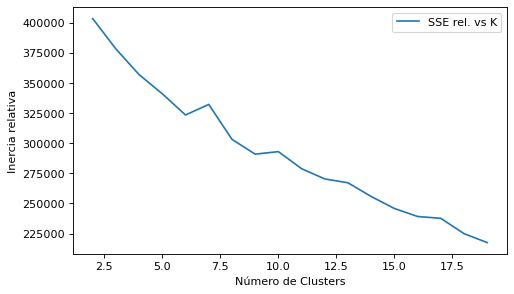

In [13]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
km = KMeans(n_clusters=1, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=1)
km.fit(X)
tss=km.inertia_
distortions = []
for i in range(2, 20):
    km = KMeans(n_clusters=i, init='k-means++', n_init='auto', max_iter=300, tol=1e-04)
    km.fit(X)
    #distortions.append(km.inertia_/tss)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(2,20), distortions, label="SSE rel. vs K")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia relativa")
plt.legend(loc='upper right')
plt.show()

__Conclusión del gráfico del codo__: no resulta muy concluyente por el escaso número de registros de la matriz X, por lo que se echa mano de otro criterio de validación intrínseca que es el criterio de la Silueta

### Criterio de la Silueta

El __coeficiente de silueta__ se calcula utilizando la __distancia media dentro del grupo (a)__ y la __distancia media del grupo más cercano (b)__ para cada muestra. El Coeficiente de silueta para una muestra es (b - a) / max(a, b). Para aclarar, b es la distancia entre una muestra y el grupo más cercano del que la muestra no forma parte. El coeficiente de silueta solo se define si el número de etiquetas es $2 \ge N_{labels} \ge N_{samples} - 1$

__El mejor valor es 1 y el peor valor es -1__. Los valores cercanos a 0 indican clústeres superpuestos. Los valores negativos generalmente indican que una muestra se ha asignado al conglomerado equivocado, ya que un conglomerado diferente es más similar.

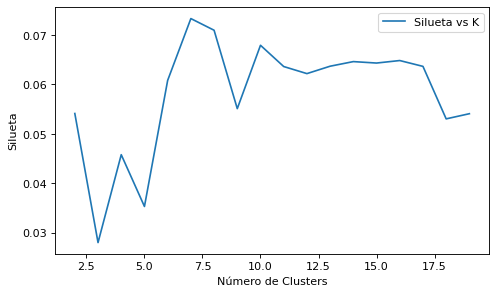

In [15]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
siluetas = []
for i in range(2, 20):
    km = KMeans(n_clusters=i, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=1)
    km.fit(X)
    silueta = metrics.silhouette_score(X,km.labels_,metric="euclidean",sample_size=1000)
    #print(i, km.inertia_, tss, km.inertia_/tss)
    siluetas.append(silueta)

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(2,20), siluetas, label="Silueta vs K")
plt.xlabel("Número de Clusters")
plt.ylabel("Silueta")
plt.legend(loc='upper right')
plt.show()

__Conclusión del gráfico de la Silueta__: Los mejores valores están primero en 8 y luego en 16 grupos.

Vamos a crear una variable con el número de grupos para poder cambiar dicho valor sin tocar el resto de código

Como se sabe que hay 14 tipos de cancer, este debería ser el valor teórico que nos debería haber salido si el clustering ajustara perfectamente la realidad

In [16]:
print("Total tipos de cancer", np.size(np.unique(labels_ok)))
totalClusters = 14

Total tipos de cancer 14


## Cluster Jerarquico

Se calcula con el número de clusters indicado anteriormente

In [18]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=totalClusters, metric='euclidean', linkage='complete', compute_distances=True)
#ac = AgglomerativeClustering(n_clusters=14, metric='euclidean', linkage='complete', distance_threshold=None)
y_ag = ac.fit_predict(X)
y_ag, ac.distances_[-1], 0.7*ac.distances_[-1], ac.n_clusters_

(array([ 2,  2,  2,  9,  1,  1,  1,  1,  0,  2,  2,  2,  2,  2,  6,  6,  6,
         4,  4,  8,  6,  6,  0,  0,  0,  0,  0,  6,  0,  0,  2,  0,  0,  3,
         3,  3,  3,  3, 13, 13, 12,  0, 10,  0, 10, 10, 10, 10,  5,  5,  5,
         5,  0,  0, 11,  7,  7,  7,  9,  7,  7,  7,  7,  7], dtype=int64),
 163.48974041519423,
 114.44281829063596,
 14)

__Se echa un primer vistazo al aspecto que tiene la agrupación conseguida__

Por cada etiqueta hacer un print de:

etiqueta - total de elementos en el grupo - lista de y_ag con ese valor de etiqueta

In [19]:
etiquetas=np.unique(y_ag) 
numEtiquetas = np.size(etiquetas)
maxSizeCluster=0
for et in etiquetas:
    print(et, np.size(y_ag[y_ag==et]), y_ag[y_ag==et])

0 14 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 4 [1 1 1 1]
2 9 [2 2 2 2 2 2 2 2 2]
3 5 [3 3 3 3 3]
4 2 [4 4]
5 4 [5 5 5 5]
6 6 [6 6 6 6 6 6]
7 8 [7 7 7 7 7 7 7 7]
8 1 [8]
9 2 [9 9]
10 5 [10 10 10 10 10]
11 1 [11]
12 1 [12]
13 2 [13 13]


__Se lista con mayor detalle los grupos obtenidos y los tipos de cancer asignados a cada uno de ellos con su nombre__

In [20]:
pd.set_option('display.width', 1000)
tiposCancerGrupo = ['' for i in range(numEtiquetas)]
for iCancer in range(np.size(y_ag)):
    iCluster = y_ag[iCancer]
    tiposCancerGrupo[iCluster] += str(labels_ok[iCancer]) + ";"

for i in range(np.size(tiposCancerGrupo)):
    print(i, tiposCancerGrupo[i])

0 ['NSCLC'];['MELANOMA'];['PROSTATE'];['OVARIAN'];['OVARIAN'];['OVARIAN'];['OVARIAN'];['PROSTATE'];['NSCLC'];['NSCLC'];['COLON'];['COLON'];['NSCLC'];['NSCLC'];
1 ['BREAST'];['CNS'];['CNS'];['BREAST'];
2 ['CNS'];['CNS'];['CNS'];['NSCLC'];['RENAL'];['RENAL'];['RENAL'];['RENAL'];['NSCLC'];
3 ['LEUKEMIA'];['K562B-repro'];['K562A-repro'];['LEUKEMIA'];['LEUKEMIA'];
4 ['BREAST'];['NSCLC'];
5 ['MCF7A-repro'];['BREAST'];['MCF7D-repro'];['BREAST'];
6 ['RENAL'];['RENAL'];['RENAL'];['UNKNOWN'];['OVARIAN'];['OVARIAN'];
7 ['MELANOMA'];['BREAST'];['BREAST'];['MELANOMA'];['MELANOMA'];['MELANOMA'];['MELANOMA'];['MELANOMA'];
8 ['RENAL'];
9 ['RENAL'];['MELANOMA'];
10 ['COLON'];['COLON'];['COLON'];['COLON'];['COLON'];
11 ['NSCLC'];
12 ['LEUKEMIA'];
13 ['LEUKEMIA'];['LEUKEMIA'];


__Función a la medida para graficar el Dendograma__

Disponible en el "__03.0ClusteringUtilidades.ipynb__"

In [21]:
run 03.0_ClusteringUtilidades.ipynb

load done!


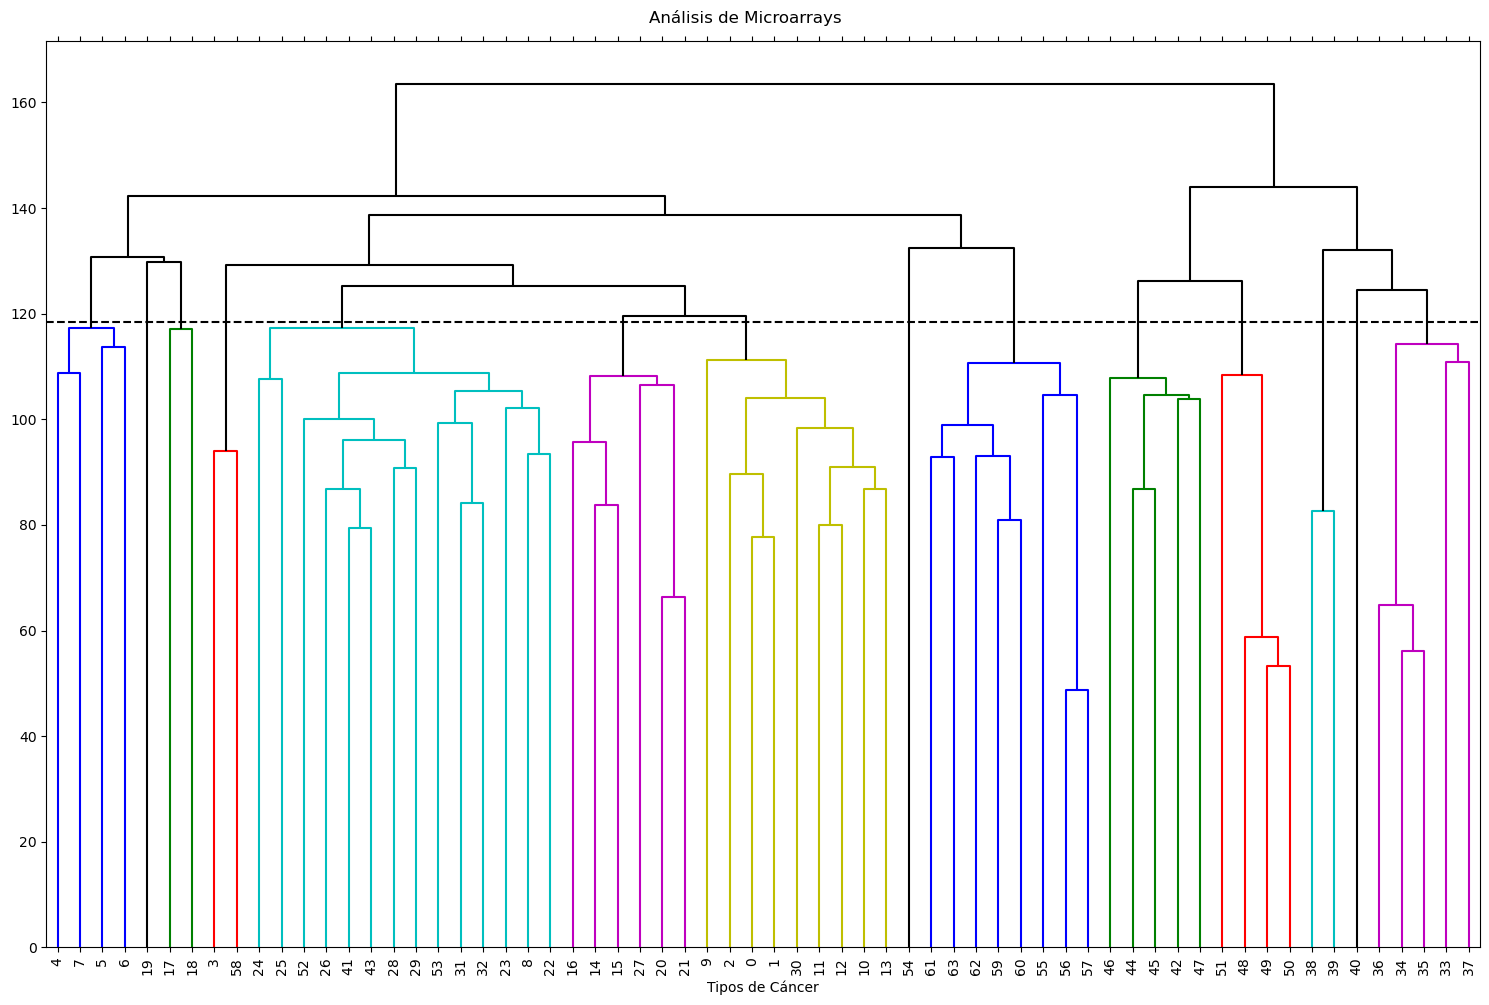

In [22]:
titulo="Análisis de Microarrays"
subtitulo="Tipos de Cáncer"
figSize=(15,10)
plot_dendrogram(ac, titulo, subtitulo, figSize, leaf_font_size=10)

## Se valida el cluster jerárquico

In [24]:
ac = AgglomerativeClustering(n_clusters=14, metric='euclidean', linkage='complete')
y_ag = ac.fit_predict(X)

In [25]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
y_ok = [lbl[0] for lbl in labels_ok]
## Rand - Puntuación de similitud entre 0.0 y 1.0, (1.0 significa coincidencia perfecta)
R=rand_score(labels_true=y_ok, labels_pred=y_ag) 
ARI=adjusted_rand_score(labels_true=y_ok, labels_pred=y_ag)
R, ARI, y_ok

(0.8720238095238095,
 0.2645020065669464,
 ['CNS',
  'CNS',
  'CNS',
  'RENAL',
  'BREAST',
  'CNS',
  'CNS',
  'BREAST',
  'NSCLC',
  'NSCLC',
  'RENAL',
  'RENAL',
  'RENAL',
  'RENAL',
  'RENAL',
  'RENAL',
  'RENAL',
  'BREAST',
  'NSCLC',
  'RENAL',
  'UNKNOWN',
  'OVARIAN',
  'MELANOMA',
  'PROSTATE',
  'OVARIAN',
  'OVARIAN',
  'OVARIAN',
  'OVARIAN',
  'OVARIAN',
  'PROSTATE',
  'NSCLC',
  'NSCLC',
  'NSCLC',
  'LEUKEMIA',
  'K562B-repro',
  'K562A-repro',
  'LEUKEMIA',
  'LEUKEMIA',
  'LEUKEMIA',
  'LEUKEMIA',
  'LEUKEMIA',
  'COLON',
  'COLON',
  'COLON',
  'COLON',
  'COLON',
  'COLON',
  'COLON',
  'MCF7A-repro',
  'BREAST',
  'MCF7D-repro',
  'BREAST',
  'NSCLC',
  'NSCLC',
  'NSCLC',
  'MELANOMA',
  'BREAST',
  'BREAST',
  'MELANOMA',
  'MELANOMA',
  'MELANOMA',
  'MELANOMA',
  'MELANOMA',
  'MELANOMA'])

__Acceso a las rutinas de cálculo de la Variación de Información de Meilă__

In [26]:
from sklearn.metrics.cluster import mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
VI = variationInformation(y_ok, y_ag)
## El VI devuelve un valor de 0 cuando las dos particiones son idénticas (es decir, coinciden perfectamente)
## El VI ajustado es un valor independiente del número de registros N
adj_VI = adjustedVariationInformation(y_ok, y_ag)
VI, adj_VI

(0.24428598854978256, 0.05873836403990491)

## Representación desde PCA

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)
Varianzas=pca.explained_variance_ratio_

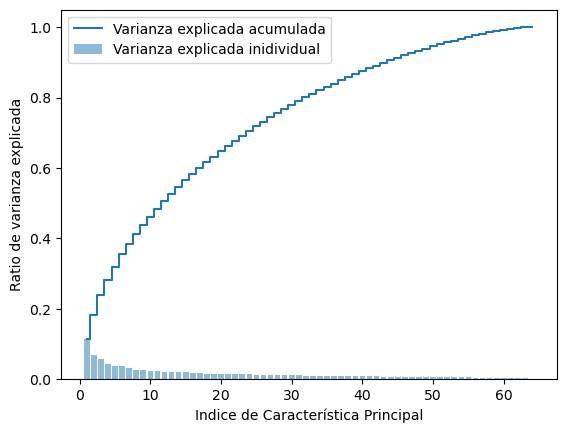

In [28]:
var_exp = pca.explained_variance_ratio_
tot = len(var_exp)
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,tot+1), var_exp, alpha=0.5, align='center',label='Varianza explicada inidividual')
plt.step(range(1,tot+1), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Ratio de varianza explicada')
plt.xlabel('Indice de Característica Principal')
plt.legend(loc='best')
plt.show()

In [29]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

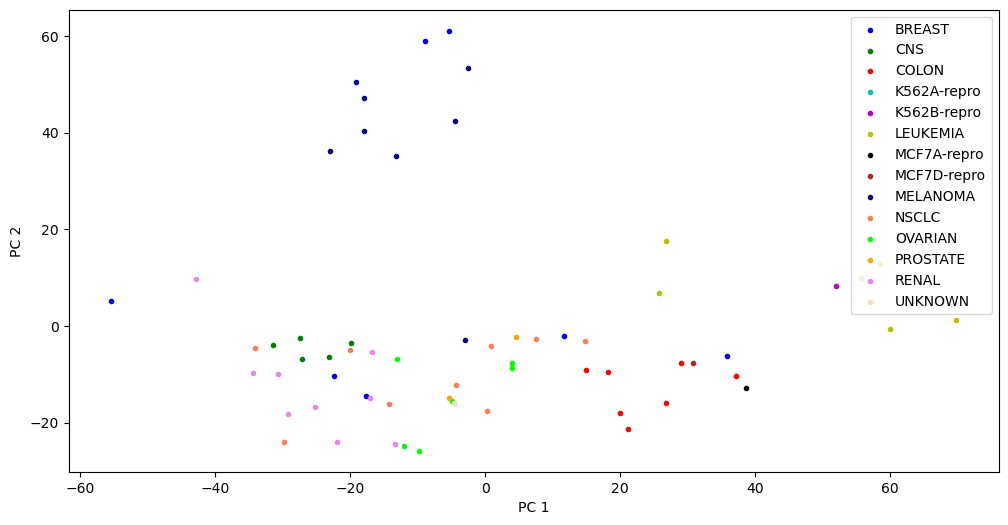

In [30]:
lstEtiquetas = np.squeeze(labels_ok, axis=1)
etiquetas=np.unique(lstEtiquetas)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'navy', 'coral', 'lime', 'orange', 'violet', 'wheat']
plt.figure(figsize=(12, 6))
for l, c in zip(etiquetas, colors):
    plt.scatter(X_pca[lstEtiquetas==l, 0], X_pca[lstEtiquetas==l, 1], c=c, label=l, marker='.')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper right')
plt.show()

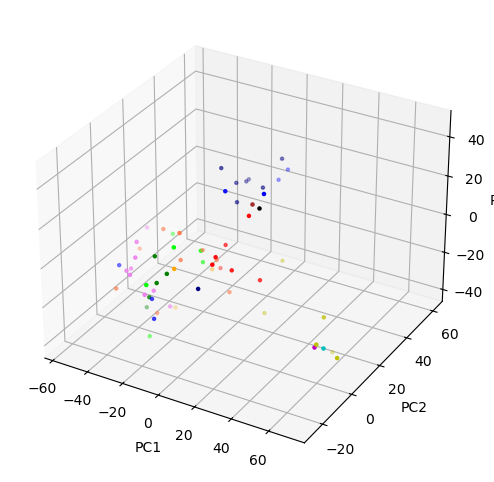

In [31]:
lstEtiquetas = np.squeeze(labels_ok, axis=1)
etiquetas=np.unique(lstEtiquetas)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'navy', 'coral', 'lime', 'orange', 'violet', 'wheat']
fig=plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
for l, color in zip(etiquetas, colors):
    #ax.scatter(X_pca[lstEtiquetas==l, 0], X_pca[lstEtiquetas==l, 1], X_pca[lstEtiquetas==l, 2], c=c, label=l, marker='.')
    ax.scatter(X_pca[lstEtiquetas==l, 0], X_pca[lstEtiquetas==l, 1], X_pca[lstEtiquetas==l, 2], c=color, label=l, marker='.')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

#plt.legend(loc='upper left')
plt.show()

__Método del Codo sobre las 3 componentes principales__

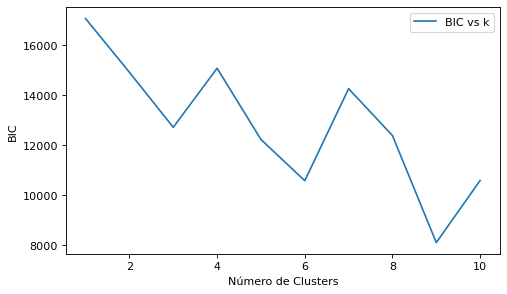

In [32]:
from sklearn.mixture import GaussianMixture
bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, init_params='kmeans')
    gmm.fit(X_pca)
    bic.append(gmm.bic(X_pca))

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(1,11), bic, label="BIC vs k")
plt.xlabel("Número de Clusters")
plt.ylabel("BIC")
plt.legend(loc='upper right')
plt.show()    